# Hands-on Image Processing with Python
## Chapter 10: Deep Learning Models in Image Processing

In [1]:
# Author: Sandipan Dey

In [1]:
import numpy as np
# import data
from keras.datasets import mnist
import tensorflow as tf
%matplotlib inline

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

np.random.seed(0)
train_indices = np.random.choice(60000, 50000, replace=False)
valid_indices = [i for i in range(60000) if i not in train_indices]
X_valid, y_valid = X_train[valid_indices,:,:], y_train[valid_indices]
X_train, y_train = X_train[train_indices,:,:], y_train[train_indices]

print(X_train.shape, X_valid.shape, X_test.shape)

C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(50000, 28, 28) (10000, 28, 28) (10000, 28, 28)


In [2]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
X_train, y_train = reformat(X_train, y_train)
X_valid, y_valid = reformat(X_valid, y_valid)
X_test, y_test = reformat(X_test, y_test)
print('Training set', X_train.shape, X_train.shape)
print('Validation set', X_valid.shape, X_valid.shape)
print('Test set', X_test.shape, X_test.shape)

Training set (50000, 784) (50000, 784)
Validation set (10000, 784) (10000, 784)
Test set (10000, 784) (10000, 784)


In [3]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [17]:
batch_size = 256 #128
num_hidden_units = 1024
lambda1 = 0.05 #0.005 #0.01
lambda2 = 0.05 #0.005 #0.01
    
graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(X_valid)
  tf_test_dataset = tf.constant(X_test)
  
  # Variables.
  weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_units]))
  biases1 = tf.Variable(tf.zeros([num_hidden_units]))

  # connect inputs to every hidden unit. Add bias
  layer_1_outputs = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)

  weights2 = tf.Variable(tf.truncated_normal([num_hidden_units, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))  

  # Training computation.
  logits = tf.matmul(layer_1_outputs, weights2) + biases2
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) + \
                        lambda1*tf.nn.l2_loss(weights1) + lambda2*tf.nn.l2_loss(weights2))  
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.003).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  layer_1_outputs = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(layer_1_outputs, weights2) + biases2)
  layer_1_outputs = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(layer_1_outputs, weights2) + biases2)  

Initialized
Minibatch loss at step 0: 90648.710938
Minibatch accuracy: 12.1%
Validation accuracy: 38.4%


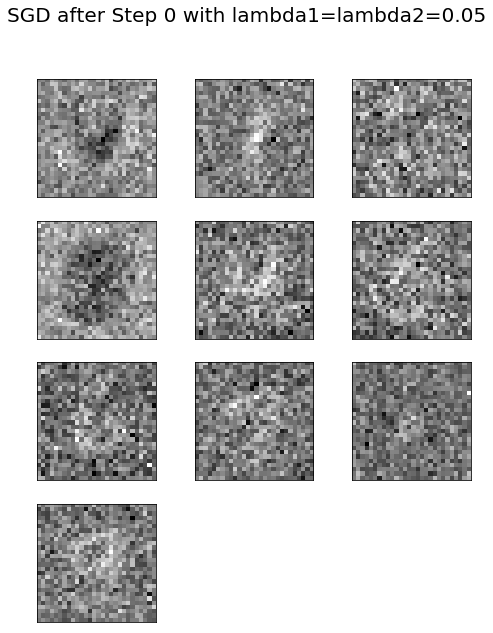

Minibatch loss at step 500: 13835.242188
Minibatch accuracy: 90.6%
Validation accuracy: 91.5%


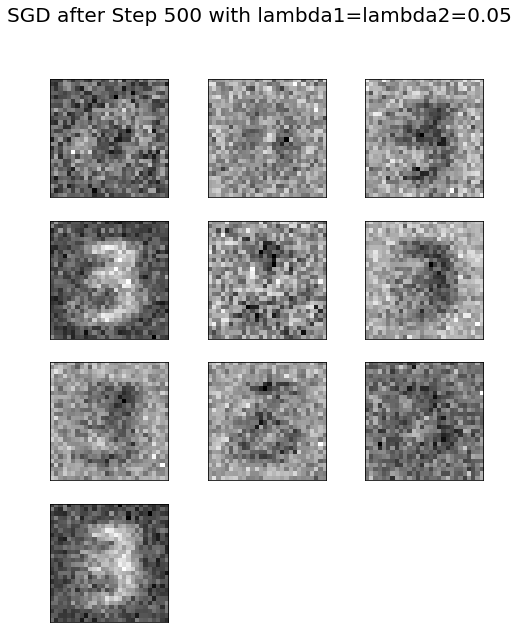

Minibatch loss at step 1000: 11822.205078
Minibatch accuracy: 96.5%
Validation accuracy: 92.0%


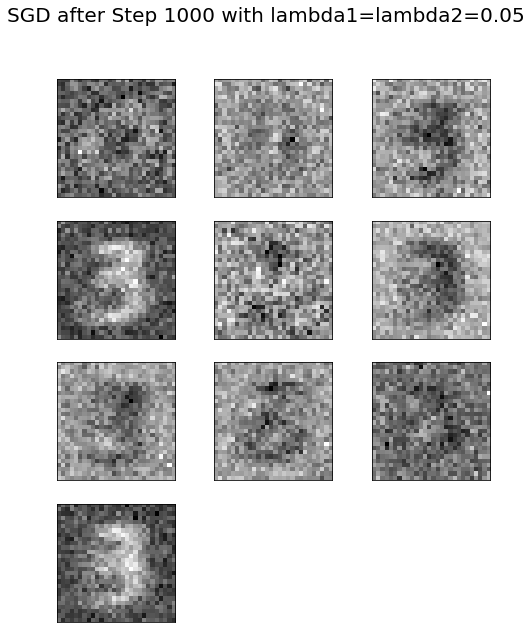

Minibatch loss at step 1500: 10164.122070
Minibatch accuracy: 98.0%
Validation accuracy: 92.3%


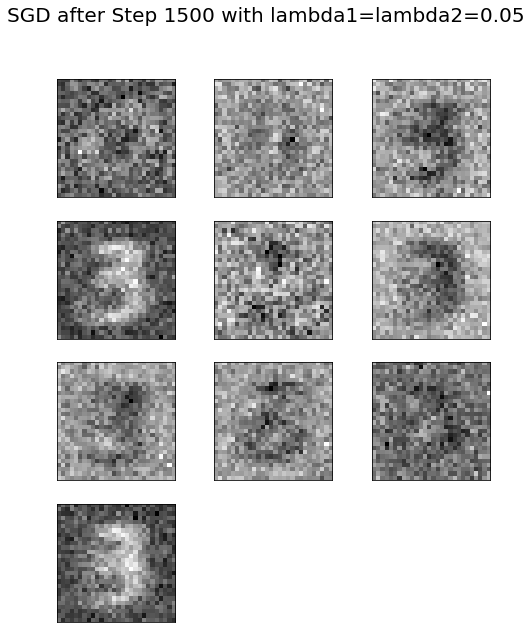

Minibatch loss at step 2000: 8748.080078
Minibatch accuracy: 98.4%
Validation accuracy: 92.6%


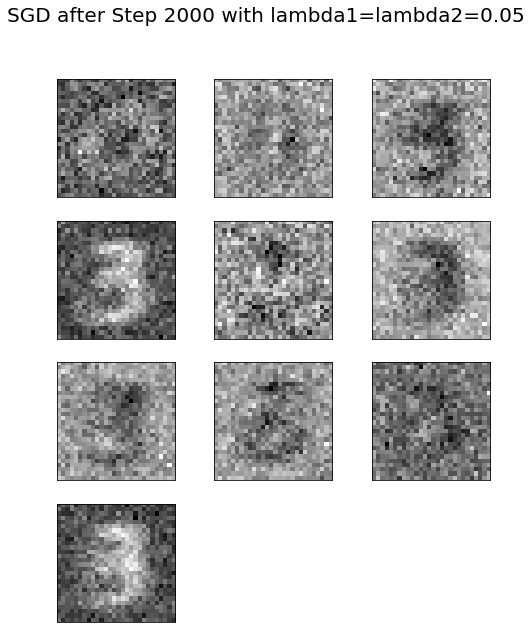

Minibatch loss at step 2500: 7526.472656
Minibatch accuracy: 98.8%
Validation accuracy: 92.5%


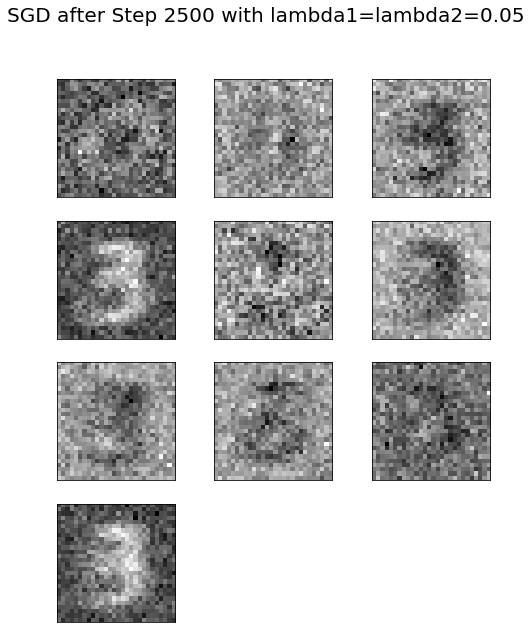

Minibatch loss at step 3000: 6478.608887
Minibatch accuracy: 98.8%
Validation accuracy: 92.5%


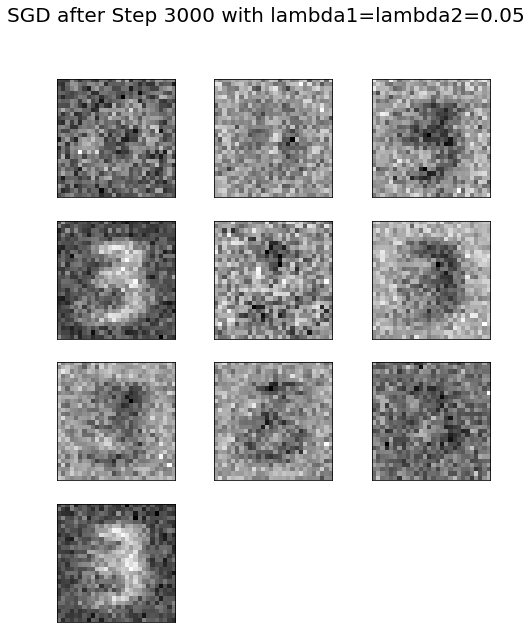

Minibatch loss at step 3500: 5575.093750
Minibatch accuracy: 98.4%
Validation accuracy: 92.5%


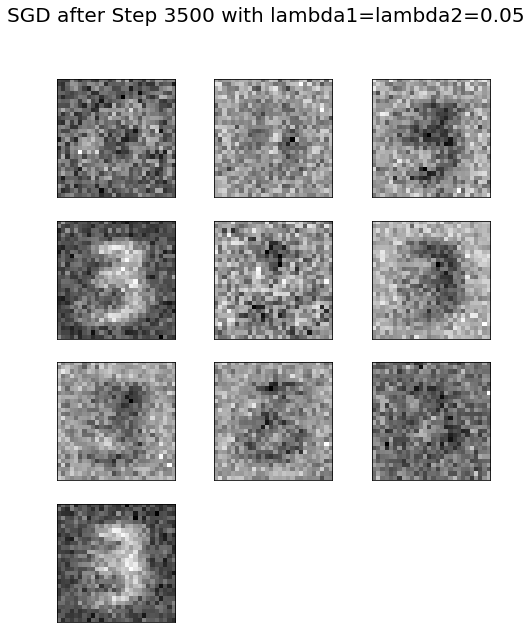

Minibatch loss at step 4000: 4798.046387
Minibatch accuracy: 98.8%
Validation accuracy: 92.5%


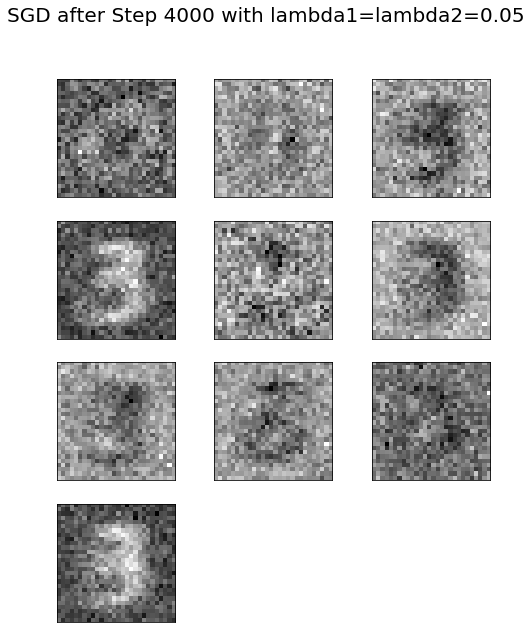

Minibatch loss at step 4500: 4130.004883
Minibatch accuracy: 98.4%
Validation accuracy: 92.5%


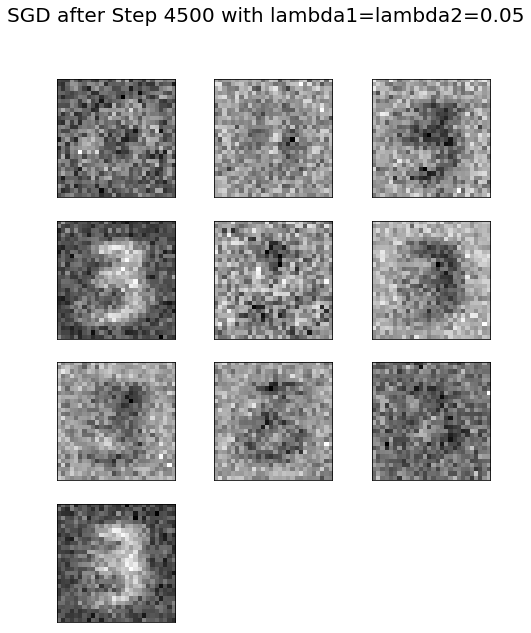

Minibatch loss at step 5000: 3554.472168
Minibatch accuracy: 99.2%
Validation accuracy: 92.5%


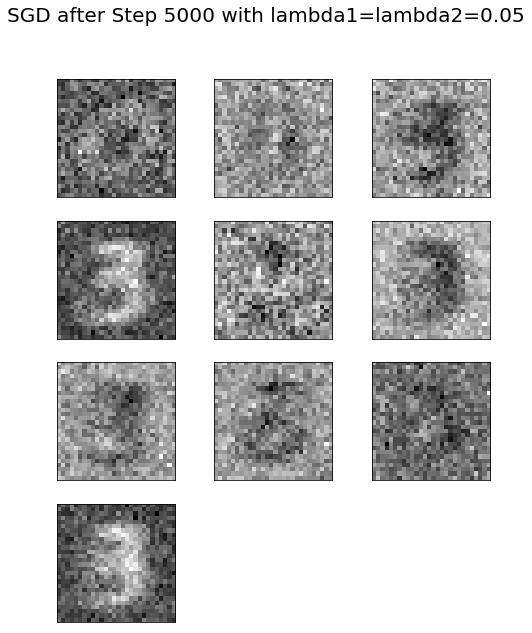

Minibatch loss at step 5500: 3059.279785
Minibatch accuracy: 99.2%
Validation accuracy: 92.4%


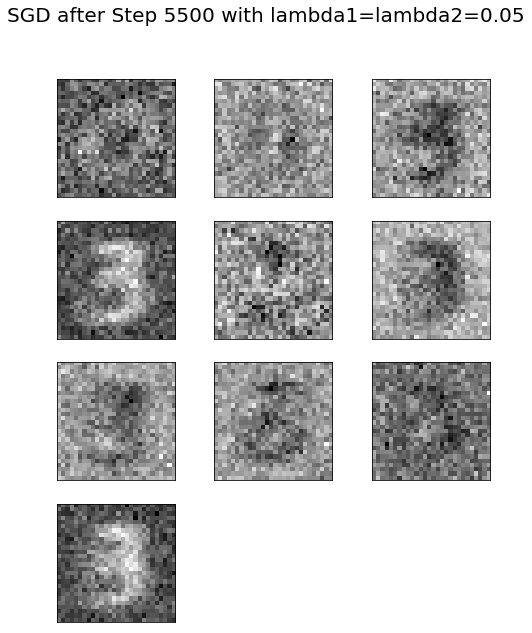

Minibatch loss at step 6000: 2633.013428
Minibatch accuracy: 100.0%
Validation accuracy: 92.5%


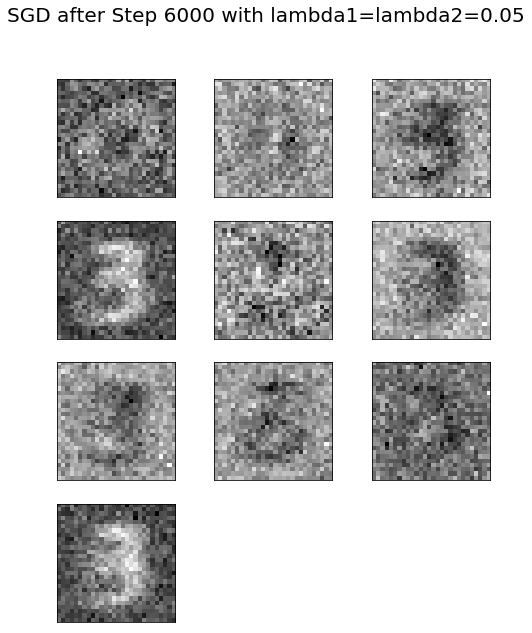

Test accuracy: 92.3%


In [18]:
num_steps = 6001

ll = []
atr = []
av = []

import matplotlib.pylab as plt

with tf.Session(graph=graph) as session:
  #tf.global_variables_initializer().run()
  session.run(tf.initialize_all_variables())
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = X_train[offset:(offset + batch_size), :]
    batch_labels = y_train[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      ll.append(l)
      a = accuracy(predictions, batch_labels)
      atr.append(a)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % a)
      a = accuracy(valid_prediction.eval(), y_valid)
      av.append(a)
      print("Validation accuracy: %.1f%%" % a)
      #images = weights1.eval()
      images = weights1.eval() @ weights2.eval()
      plt.figure(figsize=(8,10))
      #indices = np.random.choice(num_hidden_units, 225)
      for j in range(10):
        #plt.subplot(15,15,j+1);plt.imshow(np.reshape(images[:,indices[j]], (image_size,image_size)), cmap='gray');
        plt.subplot(4,3,j+1);plt.imshow(np.reshape(images[:,j], (image_size,image_size)), cmap='gray');
        plt.xticks([],[]);plt.yticks([],[])
      plt.suptitle('SGD after Step ' + str(step) + ' with lambda1=lambda2=' + str(lambda1), size=20)
      #plt.tight_layout()
      plt.show()
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), y_test))


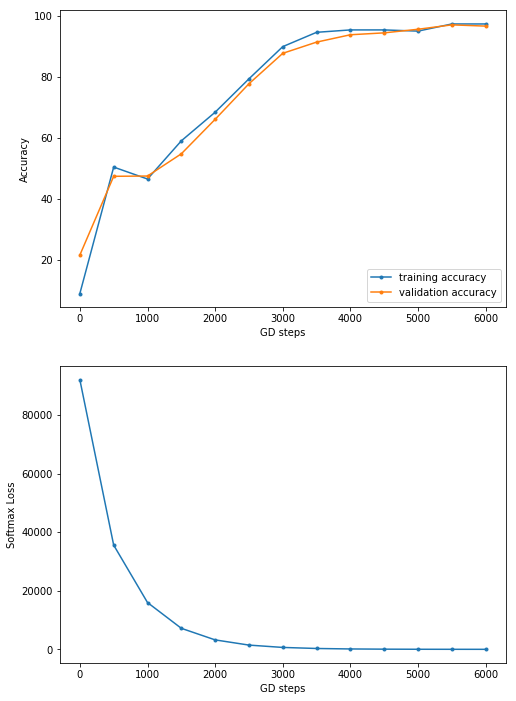

In [9]:
plt.figure(figsize=(8,12))
plt.subplot(211) 
plt.plot(range(0,6001,500), atr, '.-', label='training accuracy')
plt.plot(range(0,6001,500), av, '.-', label='validation accuracy')
plt.xlabel('GD steps')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.subplot(212) 
plt.plot(range(0,6001,500), ll, '.-')
plt.xlabel('GD steps')
plt.ylabel('Softmax Loss')
plt.show()

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import to_categorical

# import data
from keras.datasets import mnist

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, X_test.shape)

# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1] # number of categories

def convolutional_model():
    
    # create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(28,28,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
    return model

# build the model
model = convolutional_model()
model.summary()

# fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(60000, 28, 28) (10000, 28, 28)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)    

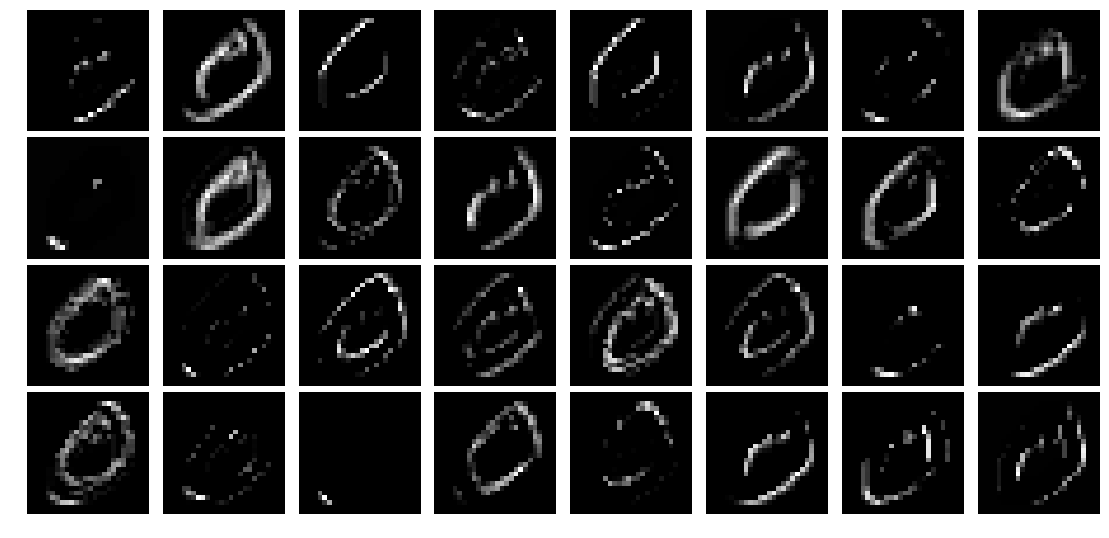

In [10]:
from keras.models import Model
import matplotlib.pylab as plt
import numpy as np

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv2d_1').output)
intermediate_output = intermediate_layer_model.predict(X_train)
print(model.input.shape, intermediate_output.shape)
fig = plt.figure(figsize=(15,7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
plt.gray()
i = 1 
for c in range(32):
    plt.subplot(4, 8, c+1), plt.imshow(intermediate_output[i,:,:,c]), plt.axis('off')
plt.show()

In [11]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv2d_2').output)
intermediate_output = intermediate_layer_model.predict(X_train)
print(model.input.shape, intermediate_output.shape)

(?, 28, 28, 1) (60000, 24, 24, 64)


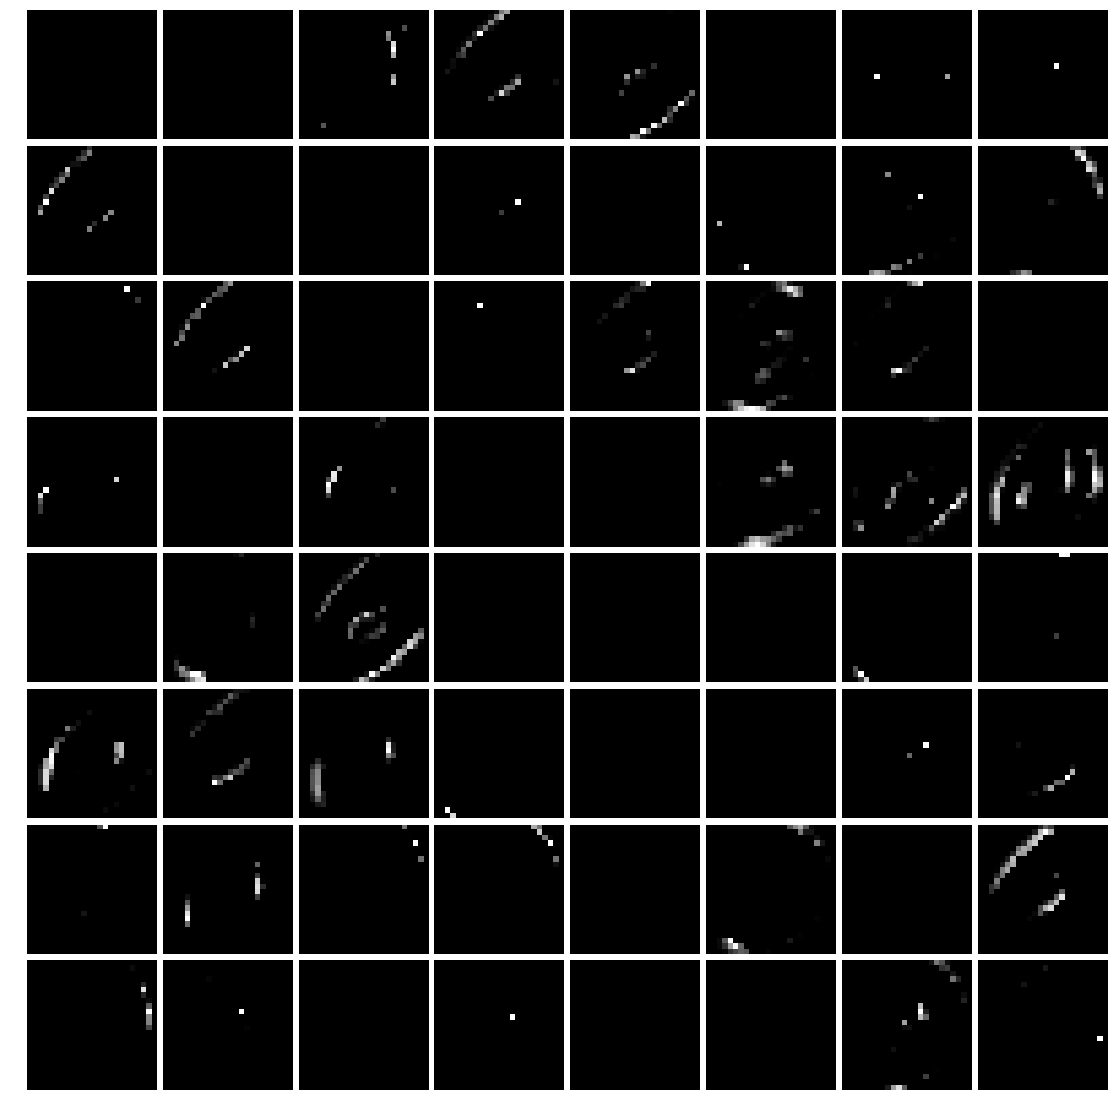

In [15]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
plt.gray()
i = 1 
for c in range(64):
    plt.subplot(8, 8, c+1), plt.imshow(intermediate_output[i,:,:,c]), plt.axis('off')
plt.show()

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.layers.convolutional import Conv2D # to add convolutional layers
from keras.layers.convolutional import MaxPooling2D # to add pooling layers
from keras.layers import Flatten # to flatten data for fully connected layers

# import data
from keras.datasets import mnist
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, X_test.shape)
# (60000, 28, 28) (10000, 28, 28)
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
X_train = X_train / 255 # normalize training data
X_test = X_test / 255 # normalize test data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1] # number of categories

def convolutional_model():    

    # create model
    model = Sequential()
    model.add(Conv2D(64, (5, 5), strides=(1, 1), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# build the model
model = convolutional_model()
model.summary()
# fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(60000, 28, 28) (10000, 28, 28)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 924,374
Trainable params: 924,374
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 49s - loss: 0.2398 - acc: 0.9289 - val_l

(?, 28, 28, 1) (60000, 24, 24, 64)


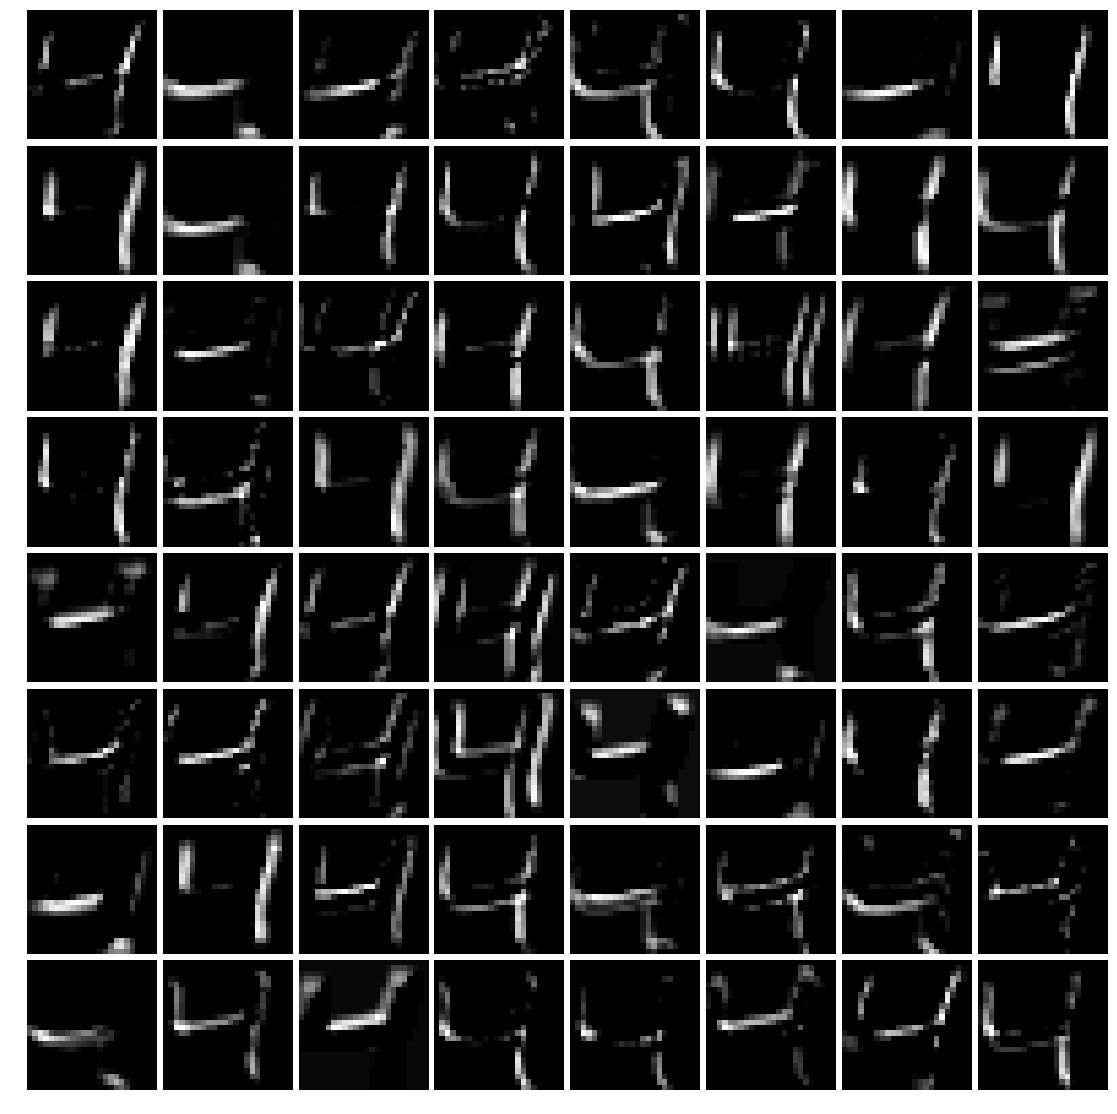

In [5]:
from keras.models import Model
import matplotlib.pylab as plt
import numpy as np
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv2d_1').output)
intermediate_output = intermediate_layer_model.predict(X_train)
print(model.input.shape, intermediate_output.shape)
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
plt.gray()
i = 2 
for c in range(64):
    plt.subplot(8, 8, c+1), plt.imshow(intermediate_output[i,:,:,c]), plt.axis('off')
plt.show()

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

# import data
from keras.datasets import mnist
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, X_test.shape)
# (60000, 28, 28) (10000, 28, 28)
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
X_train = X_train / 255 # normalize training data
X_test = X_test / 255 # normalize test data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1] # number of categories

def FC_model():    

    # create model
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# build the model
model = FC_model()
model.summary()
# fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

C:\Users\Sandipan.Dey\Anaconda\envs\ana41py35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(60000, 28, 28) (10000, 28, 28)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               157000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2010      
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 2s - loss: 0.3572 - acc: 0.8952 - val_lo

In [2]:
import pydot_ng as pydot
from keras.utils import plot_model
plot_model(model, to_file='model.png')

(784, 200) (200, 200)
(784, 10)


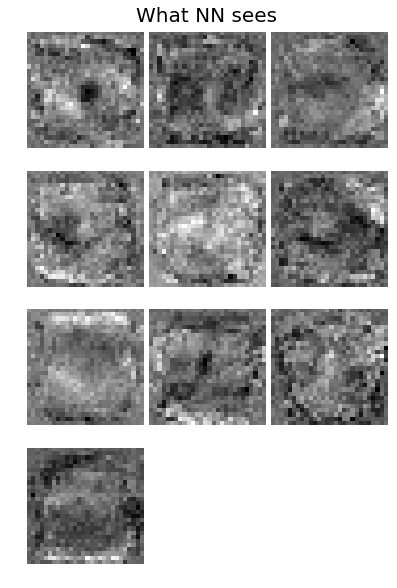

In [25]:
from keras.models import Model
import matplotlib.pylab as plt
import numpy as np
W1 = model.get_layer('dense_7').get_weights()
W2 = model.get_layer('dense_8').get_weights()
W3 = model.get_layer('dense_9').get_weights()
print(W1[0].shape, W2[0].shape)
W = W1[0] @ W2[0] @ W3[0]
print(W.shape)
fig = plt.figure(figsize=(5,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.95, hspace=0.05, wspace=0.05) 
plt.gray()
for i in range(10):
    plt.subplot(4, 3, i+1), plt.imshow(np.reshape(W[:, i], (28,28))), plt.axis('off')
plt.suptitle('What NN sees', size=20)
plt.show()

In [2]:
#! pip install pydot
#! pip install pydot_ng graphviz
import pydot_ng as pydot
from keras.utils import plot_model
plot_model(model, to_file='../new images/keras_model.png')

In [75]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion

TRAIN_DIR = 'C:\Courses\My Book\Chapter10\\train'
TEST_DIR = 'C:\Courses\My Book\Chapter10\\test'
IMG_SIZE = 50
LR = 1e-6

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

In [ ]:
TRAIN_DIR = '/home/ubuntu/train'
TEST_DIR = '/home/ubuntu/test'

In [76]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return 0
    #                             [no cat, very doggo]
    elif word_label == 'dog': return 1

In [77]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        #img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [78]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        #img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append(np.array(img))
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [79]:
train_data = create_train_data()

100%|████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [06:16<00:00, 81.31it/s]


In [80]:
len(train_data)
#train_data[0]

25000

In [12]:
img = cv2.imread('../new images/horse0.jpg')
print(img.shape)
img = cv2.resize(img, (50,50))
print(img.shape)

(480, 719, 3)
(50, 50, 3)


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from tqdm import tqdm # a nice pretty percentage bar for tasks. 
from keras.utils import to_categorical


train = train_data[:-5000]
test = train_data[-5000:]
X_train = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y_train = [i[1] for i in train]
y_train = to_categorical(y_train)
print(X_train.shape, y_train.shape)

X_test = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y_test = [i[1] for i in test]
y_test = to_categorical(y_test)

num_classes = y_test.shape[1] # number of categories

model = VGG16(weights=None, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=num_classes)
model.compile(Adam(lr=LR), "categorical_crossentropy", metrics=["accuracy"]) # "adam"
model.summary()
# fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=256, verbose=2)
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: {} \n Error: {}".format(scores[1], 100-scores[1]*100))

In [30]:
from keras.models import Model
import matplotlib.pylab as plt
import numpy as np

intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('block1_conv2').output)
intermediate_output = intermediate_layer_model.predict(X_train)
print(model.input.shape, intermediate_output.shape)

(?, 50, 50, 3) (20000, 50, 50, 64)


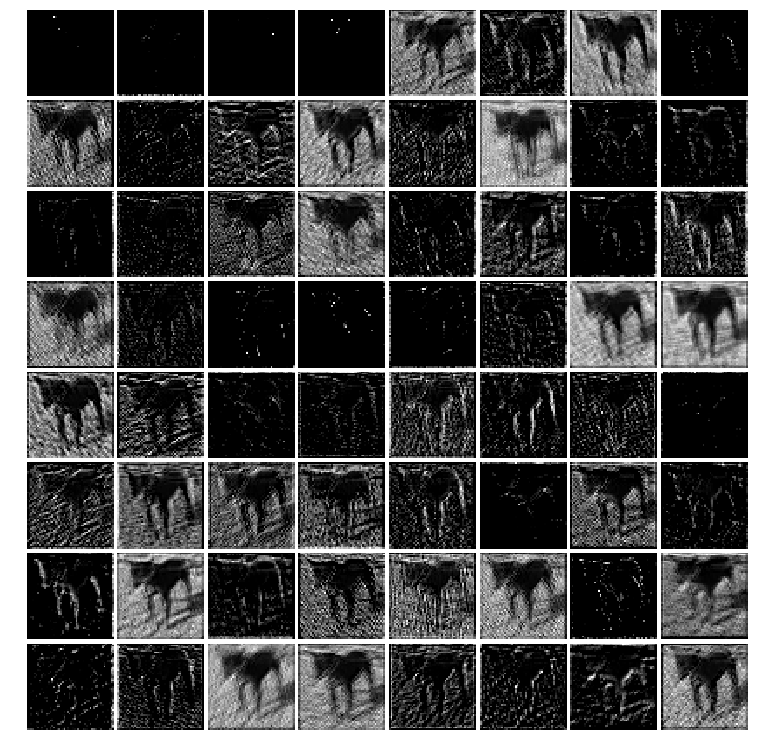

In [38]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('block1_conv2').output)
intermediate_output = intermediate_layer_model.predict(X_train)
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
plt.gray()
i = 3
for c in range(64):
    plt.subplot(8, 8, c+1), plt.imshow(intermediate_output[i,:,:,c]), plt.axis('off')
plt.show()

In [39]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('block2_conv2').output)
intermediate_output = intermediate_layer_model.predict(X_train)
print(model.input.shape, intermediate_output.shape)

(?, 50, 50, 3) (20000, 25, 25, 128)


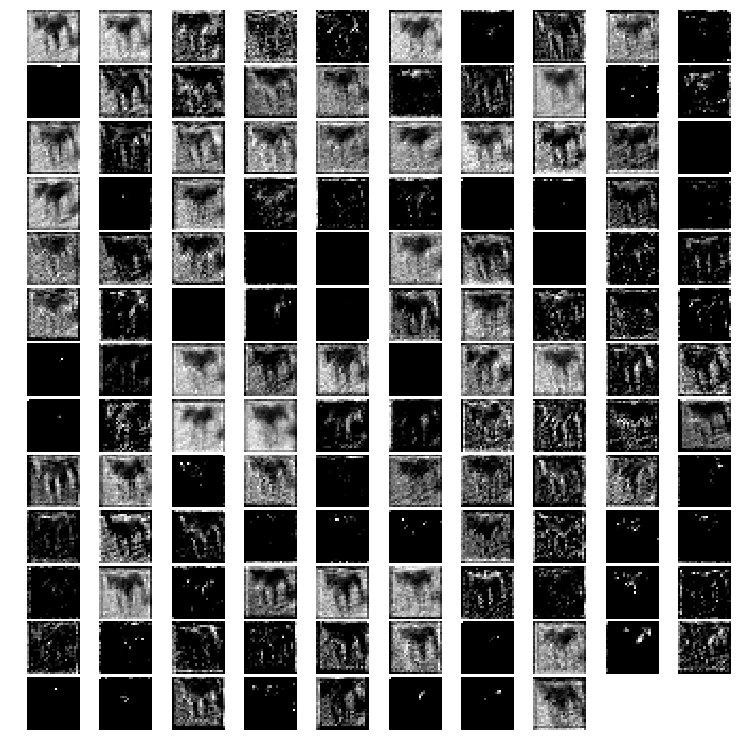

In [40]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
plt.gray()
i = 3
for c in range(128):
    plt.subplot(13, 10, c+1), plt.imshow(intermediate_output[i,:,:,c]), plt.axis('off')
plt.show()

In [41]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('block3_conv3').output)
intermediate_output = intermediate_layer_model.predict(X_train)
print(model.input.shape, intermediate_output.shape)

(?, 50, 50, 3) (20000, 12, 12, 256)


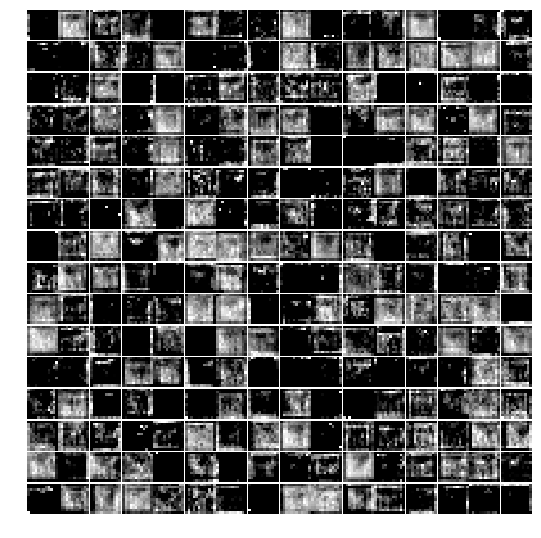

In [43]:
fig = plt.figure(figsize=(7,7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
plt.gray()
i = 3
for c in range(256):
    plt.subplot(16, 16, c+1), plt.imshow(intermediate_output[i,:,:,c]), plt.axis('off')
plt.show()

In [49]:
test_data = process_test_data()
len(test_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 429.32it/s]


1000

In [51]:
X_test = np.array([i for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
probs = model.predict(X_test)

(1000, 50, 50, 3)


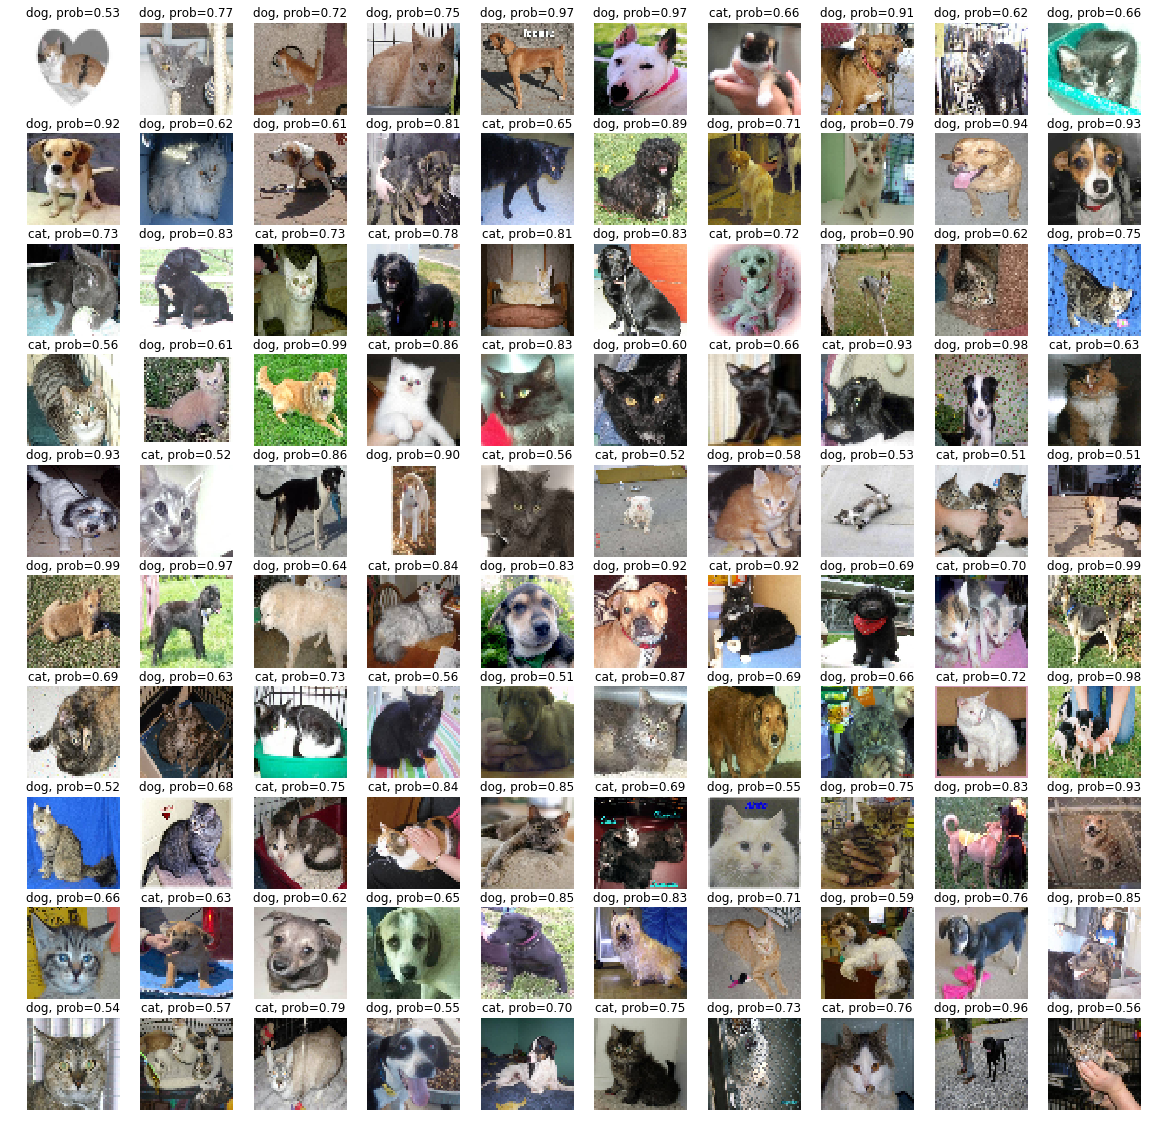

In [73]:
probs = np.round(probs,2)
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1), plt.imshow(X_test[i,:,:,::-1]), plt.axis('off')
    plt.title("{}, prob={:0.2f}".format('cat' if probs[i][1] < 0.5 else 'dog', max(probs[i][0],probs[i][1])))
plt.show()